In [1]:
import numpy as np
import matplotlib.pyplot as plt

K = 2
A = np.random.randn(K,K) + 1j*np.random.randn(K,K)
Gamma = np.conj(A).T @ A

In [19]:
L = 50000000
var1 = 1
var2 = 4

zs1 = np.random.randn(L, 2).view(np.complex128)*(np.sqrt(0.5*var1))
zs2 = np.random.randn(L, 2).view(np.complex128)*(np.sqrt(0.5*var2))
zs = np.concatenate([zs1,zs2],axis=1)

zs_outer_mean = np.einsum('li,lj->ij', zs, zs.conj()) / L
Gamma = zs_outer_mean

In [20]:
np.round(Gamma,2)

array([[1.+0.j, 0.-0.j],
       [0.+0.j, 4.+0.j]])

In [3]:
L = 500
zs1 = np.random.randn(L, 2).view(np.complex128)*(np.sqrt(2)/2)
zs2 = np.random.randn(L, 2).view(np.complex128)*(np.sqrt(2))
zs = np.concatenate([zs1,zs2],axis=1)

In [8]:
zs.shape

(500, 2)

In [4]:

def get_quadratic_func_complex(Gamma_inv):
    def func(z):
        return (z.conj().T @ Gamma_inv @ z).real
    return func

def complex_pdf_eval(Gamma, zs):
    K = Gamma.shape[1]
    Gamma_inv = np.linalg.inv(Gamma)
    Gamma_det = np.linalg.det(Gamma).real
    quad_func_complex = get_quadratic_func_complex(Gamma_inv)

    quad_complex = np.apply_along_axis(quad_func_complex, 1, zs)

    num = np.exp(-quad_complex) 
    denom = (np.pi**K * Gamma_det)
    # return num / denom 
    return num, denom, num / denom 

def get_quadratic_func_real(Gamma_real_inv):
    def func(v):
        return v.T @ Gamma_real_inv @ v
    return func

def real_pdf_eval(Gamma_real, vs):
    K = Gamma_real.shape[1]
    Gamma_real_inv = np.linalg.inv(Gamma_real)
    Gamma_real_det = np.linalg.det(Gamma_real)
    quad_func_real = get_quadratic_func_real(Gamma_real_inv)

    quad_real = np.apply_along_axis(quad_func_real, 1, vs)

    num = np.exp(-(1/2)*quad_real)
    denom = np.sqrt((2*np.pi)**K * Gamma_real_det)
    # return num / denom 
    return num, denom, num / denom 

In [5]:
from cohlib.conv import (
    conv_z_to_v, 
    conv_v_to_z,
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))

def reorder_ve2vri(v_vec_elementwise):
    """Convert [Re(z1), Im(z1), Re(z2), Im(z2)] to 
        [Re(z1), Re(z2), Im(z1), Im(z2)]
    """
    v_temp = v.reshape(-1,2)
    v_ri = np.concatenate([v_temp[:,0], v_temp[:,1]])
    return v_ri

def reorder_vri2ve(v_ri):
    v_e = v_ri.reshape(2,-1).flatten(order='F')
    return v_e

In [6]:
nums, denoms, complex_pdf_vals = complex_pdf_eval(Gamma, zs)

In [7]:
Gamma_real = quick_conv_c2r(Gamma, K)
vs = conv_z_to_v(zs, axis=1)



nums_real, denoms_real, real_pdf_vals = real_pdf_eval(Gamma_real, vs)

In [14]:
np.all(np.isclose(complex_pdf_vals, real_pdf_vals))

True

(0.0, 100.0)

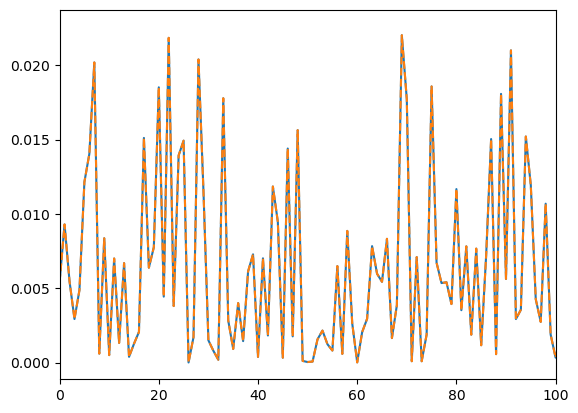

In [12]:
plt.plot(complex_pdf_vals)
plt.plot(real_pdf_vals, '--')
plt.xlim([0,100])


In [13]:
((real_pdf_vals/complex_pdf_vals)**2)[:5]

array([8., 8., 8., 8., 8.])

(0.0, 25.0)

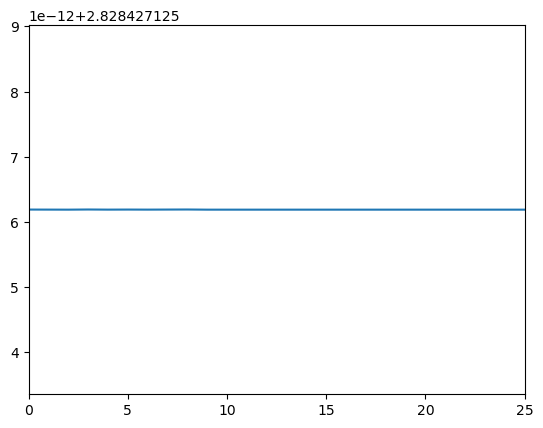

In [10]:
plt.plot(real_pdf_vals / complex_pdf_vals)
plt.xlim([0,25])

In [2]:
def complex_pdf_eval(Gamma, zs):
    Gamma_inv = np.linalg.inv(Gamma)
    K = Gamma.shape[1]



In [3]:
eigvals, _ = np.linalg.eigh(Gamma)
print(eigvals)
print(np.isclose(Gamma.conj().T, Gamma))

[0.13808853 2.18592145 8.99074016]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [66]:
from numpy.random import multivariate_normal as mvn
import warnings
def sample_zs_from_Gamma_mod(Gamma, L, seed=None):
    """Draw L samples from bcn distribution with covariances Z.
    Args:
        Z: (n_freqs, 2, 2), array of complex covs.
        L: number of samples to draw
    Returns:
        z_samples: (L, 2, n_freqs), draws from Z
    """
    n_freqs = Gamma.shape[0]
    if seed is not None:
        if np.isscalar(seed):
            np.random.seed(1)
            z_list = [sample_complex_normal_mod(Gamma[j,:,:], L) for j in range(n_freqs)]
        else:
            raise NotImplementedError
    else:
        z_list = [sample_complex_normal_mod(Gamma[j,:,:], L) for j in range(n_freqs)]
    z_join = np.stack(z_list)
    z_draws = np.swapaxes(z_join, 0, 2)

    return z_draws
def sample_complex_normal_mod(cov, n, seed=None):
    K = cov.shape[0]
    rcov = reverse_rearrange_mat(transform_cov_c2r(cov),K)
    rdim = rcov.shape[0]
    rhalfdim = int(rdim/2)
    if seed is not None:
        if np.isscalar(seed):
            np.random.seed(seed)
            zr_samps = _mvn_sample_ignore_warning(rdim, rcov, n)
        else:
            rng = np.random.default_rng(seed)
            zr_samps = _mvn_sample_ignore_warning(rdim, rcov, n, rng)
    else:
        zr_samps = _mvn_sample_ignore_warning(rdim, rcov, n)

    zc_samples = zr_samps[:,:rhalfdim] + zr_samps[:,rhalfdim:]*1j

    return zc_samples.swapaxes(0,1)

def _mvn_sample_ignore_warning(rdim, rcov, n, rng=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if rng is None:
            zr_samps = mvn(np.zeros(rdim), rcov, n)
        else:
            zr_samps = rng.multivariate_normal(np.zeros(rdim), rcov, n)

    return zr_samps

In [67]:
# from cohlib.mvcn import sample_zs_from_Gamma
# L = 100000
# zs = sample_zs_from_Gamma_mod(Gamma[None,:,:], L)
# zs = zs[:,:,0]

In [69]:
n = 500000
zs1 = np.random.randn(n, 2).view(np.complex128)*(np.sqrt(2)/2)
zs2 = np.random.randn(n, 2).view(np.complex128)*(np.sqrt(2))
zs = np.concatenate([zs1,zs2],axis=1)

zs_outer_mean = np.einsum('li,lj->ij', zs, zs.conj()) / n

In [70]:
zs_outer_mean

array([[ 9.99317184e-01+0.j        , -7.37312461e-05-0.00224939j],
       [-7.37312461e-05+0.00224939j,  4.00315246e+00+0.j        ]])

In [71]:
from cohlib.conv import conv_z_to_v, rearrange_mat, transform_cov_r2c
vs = conv_z_to_v(zs, axis=1)

In [72]:
vs_outer = np.einsum('li,lj->lij', vs, vs)
vs_outer_mean = vs_outer.mean(0)

In [73]:
Gamma_v_est = transform_cov_r2c(rearrange_mat(vs_outer_mean,K))
print(np.round(Gamma_v_est,5))
print(np.round(zs_outer_mean,5))
np.isclose(Gamma_v_est, zs_outer_mean)

[[ 9.99320e-01+0.j      -7.00000e-05-0.00225j]
 [-7.00000e-05+0.00225j  4.00315e+00+0.j     ]]
[[ 9.99320e-01+0.j      -7.00000e-05-0.00225j]
 [-7.00000e-05+0.00225j  4.00315e+00+0.j     ]]


array([[ True,  True],
       [ True,  True]])

In [78]:
zs_from_func = sample_zs_from_Gamma_mod(zs_outer_mean[None,:,:], n)
zs_from_func = zs_from_func[:,:,0]

In [80]:
zs_func_outer_mean = np.einsum('li,lj->ij', zs_from_func, zs_from_func.conj()) / n

In [83]:
zs_from_func[0,:]

array([-0.86727325+1.87642076j,  1.14102662-1.75815926j])

In [82]:
print(zs_func_outer_mean_ri2e)
print(zs_func_outer_mean)
print(zs_outer_mean)

[[ 2.49685935e+00+0.j         -2.25898283e-03-0.00197602j]
 [-2.25898283e-03+0.00197602j  2.49975292e+00+0.j        ]]
[[ 2.49685935e+00+0.j         -2.25898283e-03-0.00197602j]
 [-2.25898283e-03+0.00197602j  2.49975292e+00+0.j        ]]
[[ 9.99317184e-01+0.j         -7.37312461e-05-0.00224939j]
 [-7.37312461e-05+0.00224939j  4.00315246e+00+0.j        ]]


In [12]:
zs.shape

(100000, 3)

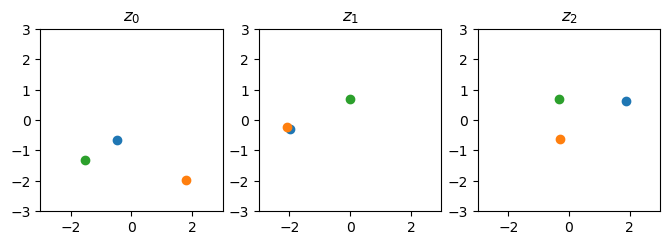

In [18]:
lim = 3
fig, ax = plt.subplots(1,3,figsize=(8,3))
for k in range(K):
    for l in range(3):
        ax[k].scatter(zs[l,k].real,zs[l,k].imag) 
    ax[k].set_aspect('equal', adjustable='box')
    ax[k].set_xlim([-lim,lim])
    ax[k].set_ylim([-lim,lim])
    ax[k].set_title(f'$z_{k}$')
    

In [120]:
zs_outer = np.einsum('li,lj->lij', zs, zs.conj())
Gamma_est = zs_outer.mean(0)
np.isclose(Gamma, Gamma_est, 1e-2)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [121]:
print(np.round(Gamma_est, 3))
print(np.round(Gamma, 3))

[[ 3.642+0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983+0.j   ]]
[[ 3.643+0.j     0.937-3.532j  1.147-1.229j]
 [ 0.937+3.532j  8.639+0.j    -3.534+4.53j ]
 [ 1.147+1.229j -3.534-4.53j  10.011+0.j   ]]


In [81]:
from cohlib.conv import conv_z_to_v, transform_cov_r2c, rearrange_mat, reverse_rearrange_mat, transform_cov_c2r


In [70]:
vs = conv_z_to_v(zs, axis=1)

In [76]:
vs_outer = np.einsum('li,lj->lij', vs, vs)
vs_outer_mean = vs_outer.mean(0)

In [77]:
Gamma_v_est = transform_cov_r2c(rearrange_mat(vs_outer_mean,K))
print(np.round(Gamma_v_est,3))
print(np.round(Gamma,3))

[[ 3.642+0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983+0.j   ]]
[[ 3.643+0.j     0.937-3.532j  1.147-1.229j]
 [ 0.937+3.532j  8.639+0.j    -3.534+4.53j ]
 [ 1.147+1.229j -3.534-4.53j  10.011+0.j   ]]


In [78]:
np.isclose(Gamma, Gamma_v_est, 1e-2)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

array([[ 1.829,  0.006,  0.46 ,  1.774,  0.572,  0.625],
       [ 0.006,  1.813, -1.757,  0.469, -0.608,  0.577],
       [ 0.46 , -1.757,  4.308, -0.006, -1.767, -2.261],
       [ 1.774,  0.469, -0.006,  4.32 ,  2.263, -1.749],
       [ 0.572, -0.608, -1.767,  2.263,  4.984, -0.005],
       [ 0.625,  0.577, -2.261, -1.749, -0.005,  4.999]])

In [82]:
vs_outer_recon = reverse_rearrange_mat(transform_cov_c2r(Gamma_v_est),K)

In [87]:
print(np.round(vs_outer_mean,3))
print(np.round(vs_outer_recon,3))
np.isclose(vs_outer_recon,vs_outer_mean, 1)

[[ 1.829  0.006  0.46   1.774  0.572  0.625]
 [ 0.006  1.813 -1.757  0.469 -0.608  0.577]
 [ 0.46  -1.757  4.308 -0.006 -1.767 -2.261]
 [ 1.774  0.469 -0.006  4.32   2.263 -1.749]
 [ 0.572 -0.608 -1.767  2.263  4.984 -0.005]
 [ 0.625  0.577 -2.261 -1.749 -0.005  4.999]]
[[ 1.821 -0.     0.465  1.766  0.575  0.616]
 [ 0.     1.821 -1.766  0.465 -0.616  0.575]
 [ 0.465 -1.766  4.314 -0.    -1.758 -2.262]
 [ 1.766  0.465  0.     4.314  2.262 -1.758]
 [ 0.575 -0.616 -1.758  2.262  4.991 -0.   ]
 [ 0.616  0.575 -2.262 -1.758  0.     4.991]]


array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [90]:
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))

def reorder_ve2vri(v_e):
    """Convert [Re(z1), Im(z1), Re(z2), Im(z2)] to 
        [Re(z1), Re(z2), Im(z1), Im(z2)]
    """
    v_temp = v_e.reshape(-1,2)
    v_ri = np.concatenate([v_temp[:,0], v_temp[:,1]])
    return v_ri

def reorder_vri2ve(v_ri):
    v_e = v_ri.reshape(2,-1).flatten(order='F')
    return v_e

In [92]:
vs_ri = np.apply_along_axis(reorder_ve2vri, 1, vs)

In [93]:
print(vs[0,:])
print(vs_ri[0,:])

[ 1.76459223 -0.81857509  1.00886131 -0.83873096 -0.194852    2.68104668]
[ 1.76459223  1.00886131 -0.194852   -0.81857509 -0.83873096  2.68104668]


In [94]:
vs_ri_outer = np.einsum('li,lj->lij', vs_ri, vs_ri)
vs_ri_outer_mean = vs_ri_outer.mean(0)

In [98]:
Gamma_v_ri_est = transform_cov_r2c(vs_ri_outer_mean)
print(np.round(Gamma_v_ri_est,3))
print(np.round(Gamma,3))
np.isclose(Gamma_est, Gamma_v_ri_est, 1e-2)

[[ 3.642+0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983+0.j   ]]
[[ 3.643+0.j     0.937-3.532j  1.147-1.229j]
 [ 0.937+3.532j  8.639+0.j    -3.534+4.53j ]
 [ 1.147+1.229j -3.534-4.53j  10.011+0.j   ]]


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [97]:
Gamma_v_est == Gamma_v_ri_est

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [139]:
zzT_sum = np.zeros((K,K), dtype=complex)
for l in range(L):
    zzT_sum += np.outer(zs[l,:], zs[l,:].conj())
Gamma_est_alt = zzT_sum / L

In [137]:
print(np.round(Gamma,3))
print(np.round(Gamma_est_alt,3))
print(np.round(Gamma_est,3))
print(np.isclose(Gamma_est_alt, Gamma_est))

[[ 3.643+0.j     0.937-3.532j  1.147-1.229j]
 [ 0.937+3.532j  8.639+0.j    -3.534+4.53j ]
 [ 1.147+1.229j -3.534-4.53j  10.011+0.j   ]]
[[ 3.642-0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983-0.j   ]]
[[ 3.642+0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983+0.j   ]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [136]:
Gamma_est_alt == Gamma_est

array([[False, False, False],
       [False, False,  True],
       [False,  True, False]])

In [145]:
vvT_sum = np.zeros((2*K,2*K))
for l in range(L):
    vvT_sum += np.outer(vs[l,:], vs[l,:])
vs_outer_mean_alt = vvT_sum / L

In [146]:
print(np.round(vs_outer_mean,3))
print(np.round(vs_outer_mean_alt,3))

[[ 1.829  0.006  0.46   1.774  0.572  0.625]
 [ 0.006  1.813 -1.757  0.469 -0.608  0.577]
 [ 0.46  -1.757  4.308 -0.006 -1.767 -2.261]
 [ 1.774  0.469 -0.006  4.32   2.263 -1.749]
 [ 0.572 -0.608 -1.767  2.263  4.984 -0.005]
 [ 0.625  0.577 -2.261 -1.749 -0.005  4.999]]
[[ 1.829  0.006  0.46   1.774  0.572  0.625]
 [ 0.006  1.813 -1.757  0.469 -0.608  0.577]
 [ 0.46  -1.757  4.308 -0.006 -1.767 -2.261]
 [ 1.774  0.469 -0.006  4.32   2.263 -1.749]
 [ 0.572 -0.608 -1.767  2.263  4.984 -0.005]
 [ 0.625  0.577 -2.261 -1.749 -0.005  4.999]]


In [147]:
Gamma_v_est_alt = transform_cov_r2c(rearrange_mat(vs_outer_mean_alt,K))

In [150]:
print(np.round(Gamma_v_est_alt,3))
print(np.round(Gamma_est_alt,3))

[[ 3.642+0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983+0.j   ]]
[[ 3.642-0.j     0.93 -3.531j  1.149-1.233j]
 [ 0.93 +3.531j  8.628+0.j    -3.516+4.524j]
 [ 1.149+1.233j -3.516-4.524j  9.983-0.j   ]]


In [153]:
np.isclose(Gamma_v_est_alt, Gamma_est_alt, 1e-9)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])